In [1]:
from utils import read_csv_data, clean_location, build_column_vocabulary, convert_to_one_hot, cat_emb

In [2]:
# Change to Categorical
data = read_csv_data("../data/processed_job_postings_large_noNA.csv", 
                     ["industry", "work_type", "location", "formatted_experience_level", "title_emb"], "salary_level")
data = clean_location(data, 2)

import random
random.seed(70)
random.shuffle(data)

train_data = data[:10000]
val_data = data[10000:13000]
test_data = data[13000:]

In [3]:
vocab_sector = build_column_vocabulary(train_data, 0)
vocab_type = build_column_vocabulary(train_data, 1)
vocab_state = build_column_vocabulary(train_data, 2)
vocab_level = build_column_vocabulary(train_data, 3)
len(vocab_type)

7

In [4]:
import torch
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

targets = [data[i][1] for i in range(len(data))]

labels = ['10K-'] + [f"{i}K - {i + 10}K" for i in range(10, 150, 10)] + ['160K+']
label_to_int = {label: i for i, label in enumerate(labels)}

targets = list(map(lambda x: label_to_int[x], targets))

targets = torch.tensor(targets)

train_targets = targets[:10000]
val_targets = targets[10000:13000]
test_targets = targets[13000:]

In [5]:
# Attempt with basic MLP

from mlp import MLPDataset
# temp looks like this
# [[Tensor1, Tensor2, Tensor3, Tensor4], ...]
temp = convert_to_one_hot(train_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
train_one_hot = MLPDataset(temp, [target.type(torch.LongTensor) for target in train_targets])



temp = convert_to_one_hot(val_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
val_one_hot = MLPDataset(temp, [target.type(torch.LongTensor) for target in val_targets])

In [8]:
from mlp import MLP_classifier, train_classifier
total_features = train_one_hot[0][0].shape[0]
model = MLP_classifier(input_size=total_features, hidden_size=1000, num_classes=len(labels))  

Iter 50: Loss: 2.6055283546447754 Train Acc: 0.1443, Validation Acc: 0.15166666666666667
Iter 100: Loss: 2.5978357791900635 Train Acc: 0.1462, Validation Acc: 0.15466666666666667
Iter 150: Loss: 2.4981627464294434 Train Acc: 0.2092, Validation Acc: 0.215
Iter 200: Loss: 2.4832444190979004 Train Acc: 0.2112, Validation Acc: 0.21333333333333335
Iter 250: Loss: 2.5573439598083496 Train Acc: 0.2258, Validation Acc: 0.22433333333333333
Iter 300: Loss: 2.3839375972747803 Train Acc: 0.2277, Validation Acc: 0.23033333333333333
Iter 350: Loss: 2.3667938709259033 Train Acc: 0.2278, Validation Acc: 0.22566666666666665
Iter 400: Loss: 2.396576166152954 Train Acc: 0.2316, Validation Acc: 0.23
Iter 450: Loss: 2.4178626537323 Train Acc: 0.2408, Validation Acc: 0.23633333333333334
Iter 500: Loss: 2.3049416542053223 Train Acc: 0.243, Validation Acc: 0.23766666666666666
Iter 550: Loss: 2.3727705478668213 Train Acc: 0.2356, Validation Acc: 0.23766666666666666
Iter 600: Loss: 2.3931875228881836 Train Acc:

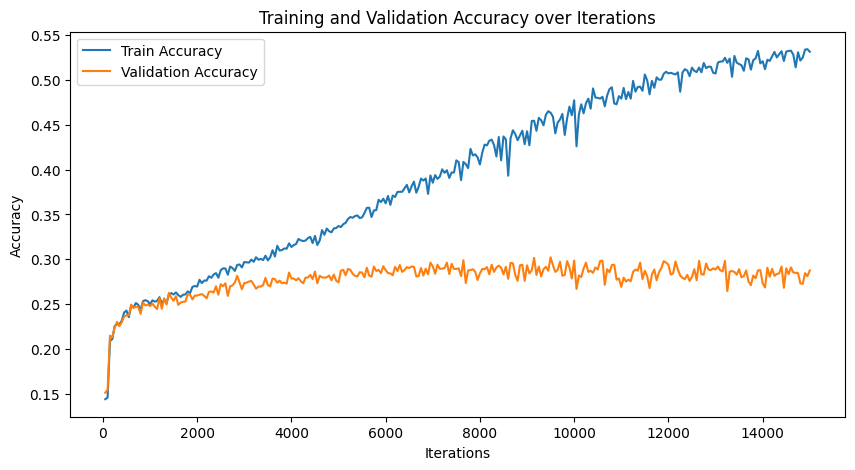

In [9]:
train_classifier(model, train_one_hot, val_one_hot, 0.1, batch_size=100, num_epochs=150)

In [10]:
from utils import accuracy

temp = convert_to_one_hot(test_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
test_one_hot_with_emb = MLPDataset(temp, [target.type(torch.LongTensor) for target in test_targets])

accuracy(model, test_one_hot_with_emb)

0.28773072747014117

In [11]:
# Attempt to add topic embedding to improve the model

from mlp import MLPDataset
# temp looks like this
# [[Tensor1, Tensor2, Tensor3, Tensor4], ...]
temp = convert_to_one_hot(train_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
temp = cat_emb(temp, train_data, 4)
train_one_hot_with_emb = MLPDataset(temp, [target.type(torch.LongTensor) for target in train_targets])
temp = convert_to_one_hot(val_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
temp = cat_emb(temp, val_data, 4)
val_one_hot_with_emb = MLPDataset(temp, [target.type(torch.LongTensor) for target in val_targets])

train_one_hot_with_emb[0]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

In [12]:
from mlp import MLP_classifier, train_classifier
total_features = train_one_hot_with_emb[0][0].shape[0]
model2 = MLP_classifier(input_size=total_features, hidden_size=1000, num_classes=len(labels))  

Iter 50: Loss: 2.6773743629455566 Train Acc: 0.1443, Validation Acc: 0.15166666666666667
Iter 100: Loss: 2.571209192276001 Train Acc: 0.1443, Validation Acc: 0.15166666666666667
Iter 150: Loss: 2.600278615951538 Train Acc: 0.2, Validation Acc: 0.20933333333333334
Iter 200: Loss: 2.5429506301879883 Train Acc: 0.2138, Validation Acc: 0.21966666666666668
Iter 250: Loss: 2.412264347076416 Train Acc: 0.2228, Validation Acc: 0.22933333333333333
Iter 300: Loss: 2.2804067134857178 Train Acc: 0.2251, Validation Acc: 0.23066666666666666
Iter 350: Loss: 2.225717067718506 Train Acc: 0.2337, Validation Acc: 0.24166666666666667
Iter 400: Loss: 2.2002036571502686 Train Acc: 0.2511, Validation Acc: 0.25266666666666665
Iter 450: Loss: 2.359544277191162 Train Acc: 0.2593, Validation Acc: 0.265
Iter 500: Loss: 2.172795534133911 Train Acc: 0.2698, Validation Acc: 0.2733333333333333
Iter 550: Loss: 2.170483350753784 Train Acc: 0.2691, Validation Acc: 0.274
Iter 600: Loss: 2.121281623840332 Train Acc: 0.266

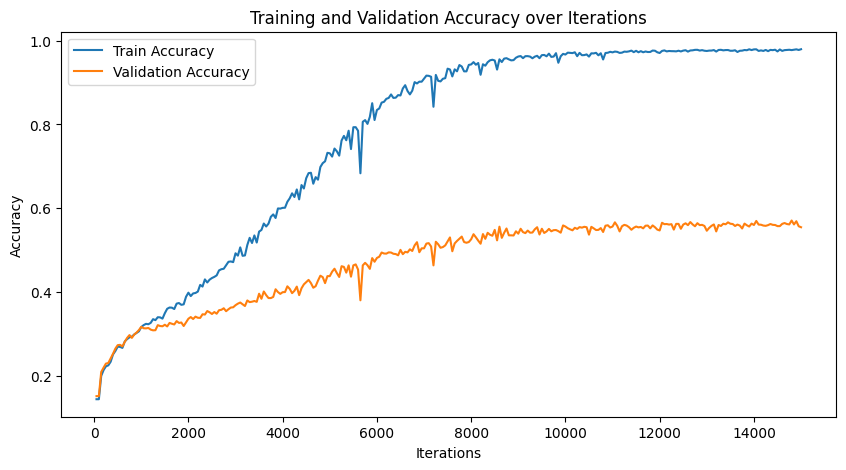

In [13]:
train_classifier(model2, train_one_hot_with_emb, val_one_hot_with_emb, 0.1, batch_size=100, num_epochs=150)

In [14]:
from utils import accuracy

temp = convert_to_one_hot(test_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
temp = cat_emb(temp, test_data, 4)
test_one_hot_with_emb = MLPDataset(temp, [target.type(torch.LongTensor) for target in test_targets])

accuracy(model2, test_one_hot_with_emb)

0.5884907709011944